<a href="https://colab.research.google.com/github/abhinavj98/machine-learning/blob/master/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from random import randint
import  os
import numpy as np


TensorFlow 1.x selected.


In [0]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [4]:
print("Train Images:", train_images.shape, "Test Images:", test_images.shape)
label_text = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

Train Images: (60000, 28, 28) Test Images: (10000, 28, 28)


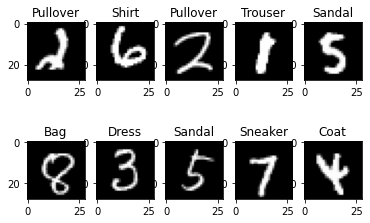

In [5]:
for i in range(10):
  j = randint(0,60000)
  plt.subplot(2,5,i+1)
  plt.title(label_text[train_labels[j]])
  plt.imshow(train_images[j], cmap = 'gray')
plt.show()

In [6]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images/255.0
test_images = test_images/255.0
print(train_images[0])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

In [0]:
class GAN:
  def make_model(self):
    self.gen = self.generator()
    self.dis = self.discriminator()
        
  def run_generator(self, z, is_training):
    x = self.gen['dense1'](z)
    x = self.gen['dropout1'](x, is_training)
    x = self.gen['bnorm1'](x, is_training)
    x = tf.reshape(x, (-1,7,7,1))
    x = self.gen['convt1'](x)
    x = self.gen['dropout2'](x, is_training)
    x = self.gen['bnorm2'](x, is_training)
    # output = self.gen['convt2'](x)
    x = self.gen['dropout3'](x, is_training)
    x = self.gen['bnorm3'](x, is_training)
    x = self.gen['convt3'](x)
    x = self.gen['dropout4'](x, is_training)
    x = self.gen['bnorm4'](x, is_training)
    output = self.gen['convt4'](x)
    return output
  
  def run_discriminator(self, z):
    x = self.dis['conv1'](z)
    x = self.dis['dropout1'](x)
    x = self.dis['conv2'](x)
    x = self.dis['dropout2'](x)
    x = self.dis['conv3'](x)
    x = self.dis['dropout3'](x)
    x = self.dis['flatten'](x)
    logits = self.dis['dense1'](x)
    output = self.dis['logits'](x)
    return logits, output
  
  def generator(self):
    layers = {}
    keep_prob = 0.3
    momentum = 0.99
    nodes = 7 * 7
    layers['dense1'] = tf.keras.layers.Dense(units=nodes, activation=tf.nn.leaky_relu, name = 'gen/dense1')
    layers['dropout1'] = tf.keras.layers.Dropout(keep_prob, name = 'gen/dropout1')      
    layers['bnorm1'] = tf.keras.layers.BatchNormalization(momentum = momentum, name = 'gen/bnorm1')  
    layers['convt1'] = tf.keras.layers.Conv2DTranspose(kernel_size=5, filters=128, strides=2, padding='same', activation=tf.nn.leaky_relu, name = 'gen/convt1')
    layers['dropout2'] = tf.keras.layers.Dropout(keep_prob, name = 'gen/dropout2')
    layers['bnorm2'] = tf.keras.layers.BatchNormalization(momentum=momentum, name = 'gen/bnorm2')
    layers['convt2'] = tf.layers.Conv2DTranspose(kernel_size=3, filters=64, strides=2, padding='same', activation=tf.nn.leaky_relu, name = 'gen/convt2')
    layers['dropout3'] = tf.keras.layers.Dropout(keep_prob, name = 'gen/dropout3')
    layers['bnorm3'] = tf.keras.layers.BatchNormalization(momentum=momentum, name = 'gen/bnorm3')
    layers['convt3'] = tf.layers.Conv2DTranspose(kernel_size=3, filters=1, strides=2, padding='same', activation=tf.nn.leaky_relu, name = 'gen/convt3')
    layers['dropout4'] = tf.keras.layers.Dropout(keep_prob, name = 'gen/dropout4')
    layers['bnorm4'] = tf.keras.layers.BatchNormalization(momentum=momentum, name = 'gen/bnorm4')
    layers['convt4'] = tf.keras.layers.Conv2D(kernel_size=5, filters=1, strides=1, padding='same', activation=tf.nn.sigmoid, name = 'gen/convt4')

    return layers

  def discriminator(self):
    layers = {}
    keep_prob = 0.5
    layers['conv1'] = tf.keras.layers.Conv2D(kernel_size=5, filters=64, strides=2, padding='same', activation=tf.nn.leaky_relu, input_shape = (28,28,1), name = 'dis/conv1')
    layers['dropout1'] = tf.keras.layers.Dropout(keep_prob, name = 'dis/dropout1')
    layers['conv2'] = tf.keras.layers.Conv2D(kernel_size=5, filters=64, strides=2, padding='same', activation=tf.nn.leaky_relu, name = 'dis/conv2')
    layers['dropout2'] = tf.keras.layers.Dropout(keep_prob,name = 'dis/dropout2')
    layers['conv3'] = tf.keras.layers.Conv2D(kernel_size=5, filters=64, strides=1, padding='same', activation=tf.nn.leaky_relu, name = 'dis/conv3')
    layers['dropout3'] = tf.keras.layers.Dropout(keep_prob, name = 'dis/dropout3')
    layers['flatten'] = tf.keras.layers.Flatten(name = 'dis/flatten')
    layers['dense1']=tf.keras.layers.Dense(units=128,activation=tf.nn.leaky_relu, name = 'dis/dense1')
    layers['logits']=tf.keras.layers.Dense(units=1, activation = tf.nn.sigmoid, name = 'dis/logits')

    return layers
  
#   def train_step_generator(self):
    

In [0]:
def loss_func(logits_in,labels_in):
  return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))
  
  
def generate_fakes(n):
  x = np.random.rand(n,28*28)
  x = x*2-1
  return x


def dis_accuracy(D_logits, thresh, pos):
  D_logits = D_logits.reshape(-1)
  if not pos:
    return len(D_logits[np.where(D_logits < thresh)])/len(D_logits)
  else:
    return len(D_logits[np.where(D_logits > thresh)])/len(D_logits)

In [0]:
tf.get_default_graph()
tf.reset_default_graph()
fashion_GAN = GAN()
fashion_GAN.make_model()


# D_logits_fake= fashion_GAN.run_discriminator(fake_images)
# D_logits_real= fashion_GAN.run_discriminator(real_images)
# D_real_loss=loss_func(D_logits_real, tf.ones_like(D_logits_real)*0.9) #Smoothing for generalization
# D_fake_loss=loss_func(D_logits_fake, tf.zeros_like(D_logits_fake))
# D_loss=D_real_loss+D_fake_loss

In [0]:

real_images=tf.placeholder(tf.float32,shape=[None,28, 28, 1])
# fake_images=tf.placeholder(tf.float32,shape=[None,28, 28, 1])
z=tf.placeholder(tf.float32,shape=[None,100])

G = fashion_GAN.run_generator(z, True)
D_logits_real, D_output_real = fashion_GAN.run_discriminator(real_images)
D_logits_fake, D_output_fake = fashion_GAN.run_discriminator(G)
D_real_loss = loss_func(D_logits_real, tf.ones_like(D_logits_real)*0.9) #Smoothing for generalization
D_fake_loss = loss_func(D_logits_fake, tf.zeros_like(D_logits_fake)+0.1)
D_loss = (D_real_loss + D_fake_loss)/2
G_loss = loss_func(D_logits_fake,tf.ones_like(D_logits_fake))


In [0]:

samples=[] #generator examples
D_losses = []
G_losses = []

In [82]:
lr_D=0.002
lr_G=0.002
batch_size = 128
#Do this when multiple networks interact with each other
tvars=tf.trainable_variables()  #returns all variables created(the two variable scopes) and makes trainable true
d_vars=[var for var in tvars if 'dis' in var.name]
g_vars=[var for var in tvars if 'gen' in var.name]

D_trainer=tf.train.AdamOptimizer(lr_D, 0.5).minimize(D_loss,var_list=d_vars)
G_trainer=tf.train.AdamOptimizer(lr_G, 0.5).minimize(G_loss,var_list=g_vars)
epochs=1000
init=tf.global_variables_initializer()
saver = tf.train.Saver()

print(d_vars, g_vars)


[<tf.Variable 'dis/conv1/kernel:0' shape=(5, 5, 1, 64) dtype=float32>, <tf.Variable 'dis/conv1/bias:0' shape=(64,) dtype=float32>, <tf.Variable 'dis/conv2/kernel:0' shape=(5, 5, 64, 64) dtype=float32>, <tf.Variable 'dis/conv2/bias:0' shape=(64,) dtype=float32>, <tf.Variable 'dis/conv3/kernel:0' shape=(5, 5, 64, 64) dtype=float32>, <tf.Variable 'dis/conv3/bias:0' shape=(64,) dtype=float32>, <tf.Variable 'dis/dense1/kernel:0' shape=(3136, 128) dtype=float32>, <tf.Variable 'dis/dense1/bias:0' shape=(128,) dtype=float32>, <tf.Variable 'dis/logits/kernel:0' shape=(3136, 1) dtype=float32>, <tf.Variable 'dis/logits/bias:0' shape=(1,) dtype=float32>] [<tf.Variable 'gen/dense1/kernel:0' shape=(100, 49) dtype=float32>, <tf.Variable 'gen/dense1/bias:0' shape=(49,) dtype=float32>, <tf.Variable 'gen/bnorm1/gamma:0' shape=(49,) dtype=float32>, <tf.Variable 'gen/bnorm1/beta:0' shape=(49,) dtype=float32>, <tf.Variable 'gen/convt1/kernel:0' shape=(5, 5, 128, 1) dtype=float32>, <tf.Variable 'gen/convt1/

In [0]:
with tf.Session() as sess:
  l = False
  sess.run(init)
  restore = False
  num_batches = train_images.shape[0]//batch_size
  if restore:
    if True or os.path.exists("/content/drive/My Drive/mnist_gan_checkpt.ckpt"):
      saver.restore(sess, "/content/drive/My Drive/mnist_gan_checkpt.ckpt")
      print("Restored model")

  print("TRAININGGGGGGGGG")
 
    
  for epoch in range(epochs):
    for i in range(num_batches):
      batch = train_images[batch_size*i:(batch_size)*(i+1)]
      batch_images = batch*2-1
      batch_images = np.reshape(batch_images, (-1,28,28,1))
      batch_z = np.random.uniform(-1,1,size=(batch_size,100))
      sess.run(G_trainer, feed_dict={z:batch_z})
      for l in range(5):
        batch_z = np.random.uniform(-1,1,size=(batch_size,100))
        sess.run(D_trainer, feed_dict = {real_images:batch_images,z:batch_z})
      
    print("on epoch{}".format(epoch))
    
    if epoch%10 == 0:
      print("Saving")
      save_path = saver.save(sess, "/content/drive/My Drive/mnist_gan_checkpt.ckpt")
      batch_z = np.random.uniform(-1,1,size=(10000,100))
      sample_z=np.random.uniform(-1,1,size=(9,100))
      gen_sample=sess.run(G,feed_dict={z:sample_z})
      # print(sample_z)
      for k in range(9):
        plt.subplot(3,3,k+1)
        plt.imshow((gen_sample[k].reshape(28,28)+1)/2, cmap = 'gray')
      plt.show()
      D_real, D_fake, lossD, lossG = sess.run([D_logits_real, D_logits_fake, D_loss, G_loss], feed_dict={real_images:np.reshape(test_images*2-1, (-1,28,28,1)), z:batch_z})
      D_acc_real = dis_accuracy(np.array(D_real), 0.5, True) 
      D_acc_fake = dis_accuracy(np.array(D_fake), 0.5, False)
      G_acc = dis_accuracy(np.array(D_fake), 0.5, True)

      print("lossD: {}, lossG: {}, accG: {}, accD: {}".format(lossD, lossG, G_acc, (D_acc_real + D_acc_fake)/2))
      samples.append(gen_sample)
      D_losses.append(lossD)
      G_losses.append(lossG)

   
    


TRAININGGGGGGGGG


In [0]:
 with tf.Session() as sess:
  sess.run(init)
  restore = True
  if restore:
    if os.path.exists("/content/drive/My Drive/checkpoint"):
      saver.restore(sess, "/content/drive/My Drive/checkpt.ckpt")
      print("Restored model")
    sample_z = np.random.uniform(-1,1,(10,100))
    gen_sample=sess.run(fashion_GAN.run_generator(z, False),feed_dict={z:sample_z})
      


In [0]:
gen_sample[1][:,:].shape

In [0]:
for i in range(11):
  plt.subplot(2,6,i+1)
  plt.imshow(((gen_sample[i, :, :])))
plt.show()

In [0]:
with tf.Session() as sess:
  sess.run(init)
  for epoch in range(epochs):
    if epoch%100 == 0:
      print("Saving")
#       save_path = saver.save(sess, "/content/drive/My Drive/checkpt.ckpt")
      num_batches=train_images.shape[0]//batch_size
    if epoch%5 == 0:
        logits_fake = sess.run([D_logits_fake], feed_dict = {fake_images : np.random.uniform(-1,1,size=(train_images.shape[0],28,28,1))})
        logits_real = sess.run([D_logits_real], feed_dict = {real_images : train_images.reshape(-1,28,28,1)})
        print("Epoch : {}, Loss_fake : {}, Loss_real: {}".format(epoch, dis_accuracy(np.array(logits_fake), 0.5, False), dis_accuracy(np.array(logits_real), 0.5, True)))
    for i in range(num_batches):
      batch = train_images[batch_size*i:(batch_size)*(i+1)]
      batch_images = batch.reshape((batch_size,28,28,1))
      batch_images = batch_images*2-1
      batch_fake = np.random.uniform(-1,1,size=(batch_size,28,28,1))
      lossD, _=sess.run([D_loss, D_trainer],feed_dict={real_images:batch_images,fake_images:batch_fake})
    

In [0]:
plt.imshow(samples[68].reshape(28,28))
plt.show()

In [0]:
examples = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(100):
      sample_z=np.random.uniform(-1,1,size=(1,100))
      gen_sample=sess.run(fashion_GAN.run_generator(z),feed_dict={z:sample_z})
      examples.append(gen_sample)

In [0]:
for i in range(11):
  plt.subplot(2,6,i+1)
  plt.imshow((samples[i].reshape(28,28)+1)/2, cmap = 'gray')
plt.show()

In [0]:
len(samples)

In [0]:
print(tf.trainable_variables())

In [0]:
with tf.Session() as sess:
  a = sess.run(G, feed_dict = {z : np.random.uniform(-1,1,size=(1,100))})

In [0]:
print(lossD)